# Matching 👬

In [67]:
# Imports
import pandas as pd
import numpy as np
import statsmodels as sm
from causalinference.causal import CausalModel
import matplotlib.pyplot as plt

In [68]:
data = pd.read_csv('/home/juliusdoebelt/documents/repos/Diploma_Thesis/data/preprocessed_data.csv')
# only select participants from the years 2008/09, 2009/10, and 2010/11
data = data[(data['year_3rd'] == "2008/09") | (data['year_3rd'] == "2009/10") | (data['year_3rd'] == "2010/11")]
important_variables = ["treat", "oweight", "sportsclub", "sport_hrs", "kommheard", "kommgotten", "kommused", "female", "born_germany", "parent_nongermany", "sportsclub_4_7", "music_4_7", "urban", "yob", "mob"]#, "abi_p", "real_p", "haupt_p"]
data = data[important_variables]
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [69]:
# create dummy variables for year of birth
data['yob'] = data['yob'].astype(str)
data = pd.get_dummies(data, columns=['yob'], drop_first=True, dtype=int)

In [70]:
print(data['yob_1998.0'])

0       0
1       0
2       0
3       0
4       0
       ..
8665    0
8666    0
8667    0
8668    0
8669    0
Name: yob_1998.0, Length: 8670, dtype: int64


# Propensity Score Estimation using Logistic Regression

In [72]:
# Prepare the data
independent_variables = ["female", "born_germany", "parent_nongermany", "sportsclub_4_7", "music_4_7", "urban", 'yob_1998.0', 'yob_1999.0', 'yob_2000.0', 'yob_2001.0',
       'yob_2002.0', 'yob_2003.0']
X = data[independent_variables]
y = data['treat']

# Fit the model
logit_model = sm.discrete.discrete_model.Logit(y, X)
result = logit_model.fit()

# Get the propensity scores
data['ps'] = result.predict(X)

print(data['ps'])

Optimization terminated successfully.
         Current function value: 0.629197
         Iterations 5
0       0.748776
1       0.649050
2       0.634653
3       0.321621
4       0.684242
          ...   
8665    0.288965
8666    0.652554
8667    0.644315
8668    0.711133
8669    0.369860
Name: ps, Length: 8670, dtype: float64


In [59]:
# Get our outcome, treatment, and matching variables as numpy arrays
# Outcome variable
Y = data['sport_hrs'].to_numpy()
# Treatment variable
D = data['treat'].to_numpy()
# Matching variables
X = data[["female", "born_germany", "parent_nongermany", "sportsclub_4_7", "music_4_7", "urban", 'yob_1998.0', 'yob_1999.0', 'yob_2000.0', 'yob_2001.0',
       'yob_2002.0', 'yob_2003.0']].to_numpy()#, "abi_p", "real_p", "haupt_p"]].to_numpy()
print(X)

# Set up our model
M = CausalModel(Y, D, X)

# Estimate the propensity score using logit
M.est_propensity(qua=None)

# Trim the score with improved algorithm trim_s to improve balance
#M.trim_s()

# If we want to use the scores elsewhere, export them
data['ps'] = M.propensity['fitted']
print(data['ps'])

[[0. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]
0       0.748787
1       0.648998
2       0.634670
3       0.321595
4       0.684285
          ...   
8665    0.290408
8666    0.652458
8667    0.644337
8668    0.711055
8669    0.369884
Name: ps, Length: 8670, dtype: float64


In [73]:
data[data['treat'] == 0]['ps'].describe()

count    4027.000000
mean        0.471141
std         0.172817
min         0.247794
25%         0.318266
50%         0.371631
75%         0.660241
max         0.822733
Name: ps, dtype: float64

In [74]:
data[data['treat'] == 1]['ps'].describe()

count    4643.000000
mean        0.591275
std         0.152257
min         0.247794
25%         0.436355
50%         0.655577
75%         0.700858
max         0.791319
Name: ps, dtype: float64

## Checking for Common Support

/home/juliusdoebelt/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/juliusdoebelt/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


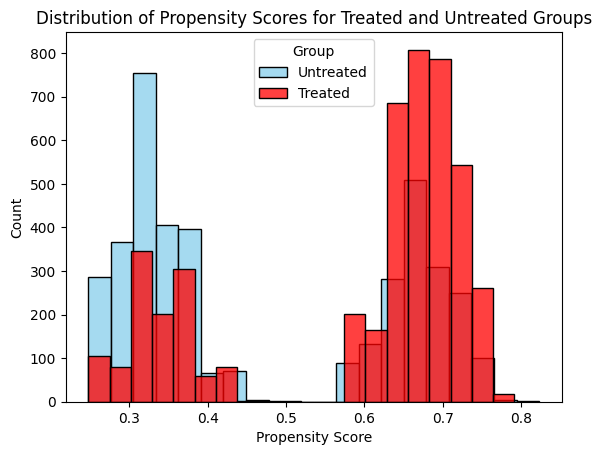

In [75]:
import seaborn as sns

sns.histplot(data[data['treat'] == 0]['ps'], color="skyblue", label='Untreated', bins=20)
sns.histplot(data[data['treat'] == 1]['ps'], color="red", label='Treated', bins=20)

plt.legend(title='Group')
plt.xlabel('Propensity Score')
plt.title('Distribution of Propensity Scores for Treated and Untreated Groups')
plt.show()

Common support seems to be given. Just a weird distribution. Influence of 'urban' is too high.

## Evaluate covariate distribution for range of the propensity score

In [81]:
def covariate_balance_for_ps_range(data: pd.DataFrame, ps_low: float, ps_high: float):
    """Takes a dataframe and range for the propensity score and checks the covariate balance for the given range.
    Outputs the mean values of all individuals for the given range for treated and untreated individuals.
    """
    # only include relevant variables for balance checks
    data = data[["treat", "female", "born_germany", "parent_nongermany", "sportsclub_4_7", "music_4_7", "urban", 'yob_1998.0', 'yob_1999.0', 'yob_2000.0', 'yob_2001.0',
       'yob_2002.0', 'yob_2003.0', 'ps']]
    treated = data[(data['ps'] >= ps_low) & (data['ps'] <= ps_high) & (data['treat'] == 1)]
    untreated = data[(data['ps'] >= ps_low) & (data['ps'] <= ps_high) & (data['treat'] == 0)]

    treated_mean = treated.mean()
    untreated_mean = untreated.mean()

    # concat the two dataframes
    balance = pd.concat([treated_mean, untreated_mean], axis=1).round(2)
    balance.columns = ['Treated', 'Untreated']

    # add standardized difference
    balance['Standardized Difference'] = ((balance['Treated'] - balance['Untreated']) / np.sqrt((treated.var() + untreated.var()) / 2)).round(2)

    return balance


balance = covariate_balance_for_ps_range(data, 0.55, 0.6)
print(balance)

                   Treated  Untreated  Standardized Difference
treat                 1.00       0.00                      inf
female                0.35       0.34                     0.02
born_germany          1.00       1.00                      NaN
parent_nongermany     0.05       0.06                    -0.04
sportsclub_4_7        1.00       1.00                      NaN
music_4_7             0.30       0.36                    -0.13
urban                 1.00       1.00                      NaN
yob_1998.0            0.00       0.00                      NaN
yob_1999.0            0.00       0.00                      NaN
yob_2000.0            0.00       0.00                      NaN
yob_2001.0            0.00       0.00                      NaN
yob_2002.0            0.99       1.00                    -0.12
yob_2003.0            0.01       0.00                     0.12
ps                    0.59       0.59                     0.00
